# EDA of cell types data 

* Implement a scalabale data storage solution 
* Perform basic exploratory data analysis 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import pandas as pd 
import numpy as np
import pprint
from pandas.io.json import json_normalize
from bson import ObjectId
import json
import seaborn as sns
from pymongo import MongoClient
import os
# connect to the locally hosted MongoDB instance
client = MongoClient('mongodb://{}:{}@localhost:27017/'.format(os.environ['MDB_USER'],os.environ['MDB_PWD']))
import os
#client.admin.authenticate(os.environ['MDB_USER'],os.environ['MDB_PWD'])

In [18]:
import matplotlib.pyplot as plt 

In [19]:
from allensdk.core.cell_types_cache import CellTypesCache, ReporterStatus as RS
from allensdk.api.queries.cell_types_api import CellTypesApi

In [20]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

In [21]:
# get human and mouse data 
human_cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
mouse_cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
print("Mouse cells: {}\nHuman cells:{}".format(len(mouse_cells),len(human_cells)))

Mouse cells: 1058
Human cells:279


In [22]:
# Get cells with reconstruction data
mouse_cell_id_w_reconstruction = [c['id'] for c in mouse_cells if c['has_reconstruction']]

In [23]:
mouse_cells_w_reconstruction = [c for c in mouse_cells if c['has_reconstruction']]

In [24]:
# use mongodb to store dataand add as necessary
db = client.aibs
coll = db.neurons

In [25]:
coll.find_one()

In [26]:
# insert all data 
coll.insert_many(mouse_cells_w_reconstruction)
coll.insert_many([c for c in human_cells if c['has_reconstruction']])
coll.count()

402

In [27]:
# sample entry
# coll.find_one()

In [28]:
# Use pandas dataframe and extract morphology data
morpho_df = pd.DataFrame.from_records(coll.find({"neuron_reconstructions":{"$exists":True}},{'id':1,'structure':1,'neuron_reconstructions':1}))

In [30]:
# Flatten nested values

records = json.loads(json_util.dumps(coll.find({"neuron_reconstructions":{"$exists":True}},{'id':1, 'donor.organism.name':1, 'structure':1, 'neuron_reconstructions':1})))

for d in records:
    d['neuron_reconstructions'] = d['neuron_reconstructions'][0] 

morpho_df = pd.DataFrame(json_normalize(records))
del morpho_df['_id.$oid']

In [31]:
for i in range(morpho_df.shape[1]): 
    print "{:<5} {:<60} {}".format(i, morpho_df.columns[i], morpho_df.iloc[0,i])


0     donor.organism.name                                          Mus musculus
1     id                                                           475459689
2     neuron_reconstructions.average_bifurcation_angle_local       75.5648348528
3     neuron_reconstructions.average_bifurcation_angle_remote      None
4     neuron_reconstructions.average_contraction                   0.897585643771
5     neuron_reconstructions.average_diameter                      0.334824510896
6     neuron_reconstructions.average_fragmentation                 40.5070422535
7     neuron_reconstructions.average_parent_daughter_ratio         0.710496521169
8     neuron_reconstructions.hausdorff_dimension                   None
9     neuron_reconstructions.id                                    491392945
10    neuron_reconstructions.max_branch_order                      8.0
11    neuron_reconstructions.max_euclidean_distance                423.262399215
12    neuron_reconstructions.max_path_distance                

In [32]:
# features of interest
cfeature_cols = [2,4,5,6,7,10,11,12,14,17,18,19,20,21,25,28,29,30,51]

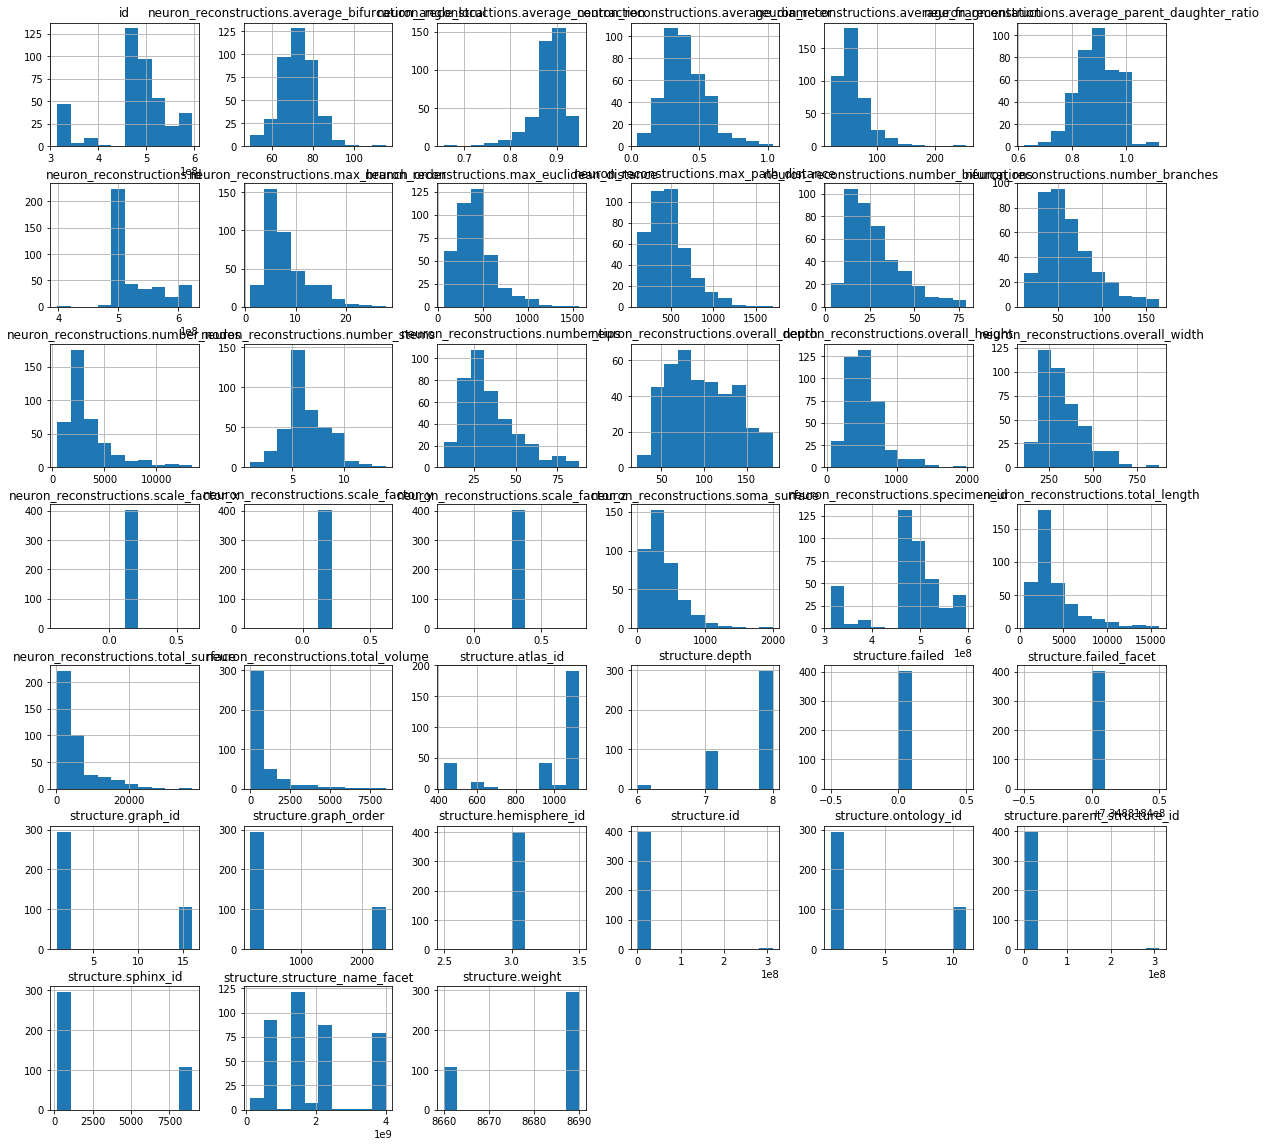

In [33]:
morpho_df.hist(figsize=(20,20));

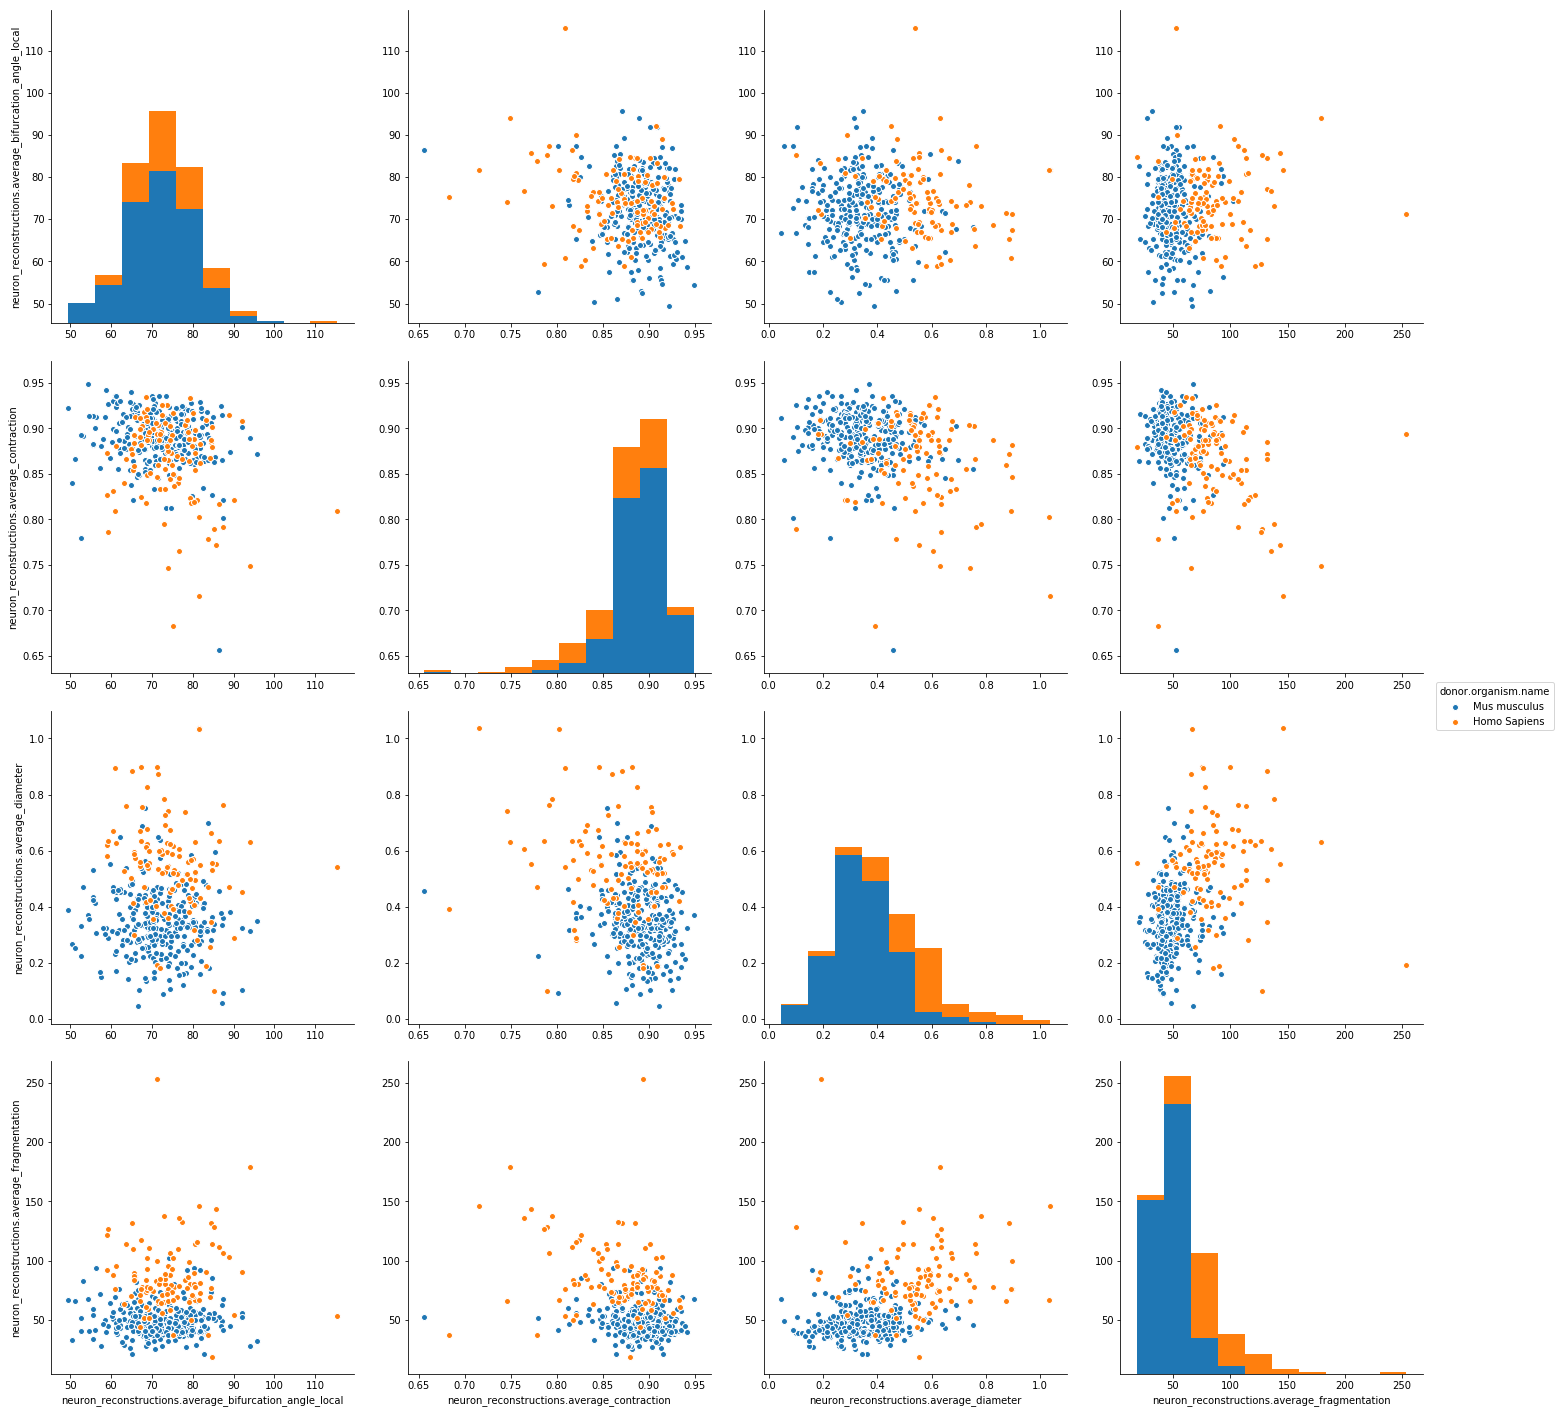

In [34]:
# Pair plot of a few features
sns.pairplot(morpho_df, vars=morpho_df.iloc[1,cfeature_cols[:4]].index.values, size=5, hue='donor.organism.name')

In [35]:
# Calculate correlations
morpho_corr = morpho_df.corr(method='pearson', min_periods=1)

In [36]:
# Observe correlations with maximum branch order 
max_order_corr = morpho_corr.loc[:,['neuron_reconstructions.max_branch_order']]\
    .sort_values(by=['neuron_reconstructions.max_branch_order'],
                 axis=0,ascending=False)
max_order_corr

,neuron_reconstructions.max_branch_order
neuron_reconstructions.max_branch_order,1.000000e+00
neuron_reconstructions.number_bifurcations,7.279140e-01
neuron_reconstructions.max_path_distance,7.250197e-01
neuron_reconstructions.number_branches,7.249350e-01
neuron_reconstructions.number_tips,7.195886e-01
neuron_reconstructions.max_euclidean_distance,6.927031e-01
neuron_reconstructions.overall_height,6.356395e-01
neuron_reconstructions.total_length,5.854389e-01
neuron_reconstructions.number_nodes,5.815721e-01
neuron_reconstructions.overall_depth,5.402567e-01


In [37]:
coll.find_one()

{u'_id': ObjectId('5a8312e93e836a10b43d9ea0'),
 u'apical': u'intact',
 u'cell_prep_sample_id': None,
 u'cell_reporter': {u'id': 491913822, u'name': u'cre reporter positive'},
 u'cell_reporter_id': 491913822,
 u'cell_soma_locations': [{u'id': 487066132,
   u'normalized_depth': 0.455007800183141,
   u'reference_space_id': 9,
   u'specimen_id': 475459689,
   u'x': 7940.0,
   u'y': 1017.19505644508,
   u'z': 3133.91316613295}],
 u'cortex_layer_id': None,
 u'data': None,
 u'data_sets': [{u'blue_channel': None,
   u'delegate': False,
   u'expression': False,
   u'failed': False,
   u'failed_facet': 734881840,
   u'green_channel': None,
   u'id': 476823581,
   u'name': u'T301-Ax.150428_01_B05_475459689',
   u'plane_of_section_id': 1,
   u'qc_date': None,
   u'red_channel': None,
   u'reference_space_id': 9,
   u'rnaseq_design_id': None,
   u'section_thickness': 0.28,
   u'specimen_id': 475459689,
   u'sphinx_id': 168053,
   u'storage_directory': u'/external/mousecelltypes/prod461/image_series